In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score, auc

## Data download

In [ ]:
url = 'https://raw.githubusercontent.com/DaPlayfulQueen/DE_track_data/master/garments_worker_productivity.csv'
df = pd.read_csv(url)
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [ ]:
df.loc[:,
    ['date', 'department', 'team','quarter', 'day',
       'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
       'no_of_style_change', 'no_of_workers']
]

,date,department,team,quarter,day,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,1/1/2015,sweing,8,Quarter1,Thursday,26.16,1108.0,7080,98,0.0,0,0,59.0
1,1/1/2015,finishing,1,Quarter1,Thursday,3.94,NaN,960,0,0.0,0,0,8.0
2,1/1/2015,sweing,11,Quarter1,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5
3,1/1/2015,sweing,12,Quarter1,Thursday,11.41,968.0,3660,50,0.0,0,0,30.5
4,1/1/2015,sweing,6,Quarter1,Thursday,25.90,1170.0,1920,50,0.0,0,0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,finishing,10,Quarter2,Wednesday,2.90,NaN,960,0,0.0,0,0,8.0
1193,3/11/2015,finishing,8,Quarter2,Wednesday,3.90,NaN,960,0,0.0,0,0,8.0
1194,3/11/2015,finishing,7,Quarter2,Wednesday,3.90,NaN,960,0,0.0,0,0,8.0
1195,3/11/2015,finishing,9,Quarter2,Wednesday,2.90,NaN,1800,0,0.0,0,0,15.0


## Preprocessing fixes

In [ ]:
df.date = pd.to_datetime(df.date).dt.date
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [ ]:
def fix_department(value: str) -> str:
  value = value.strip()
  value = 'sewing' if value == 'sweing' else value
  return value

df.department = df.department.apply(fix_department)
df.department.value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

## Initial exploration

How many teams and shifts there are?

In [ ]:
pie_formatting = lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(shifts_dep_counts) / 100, p)

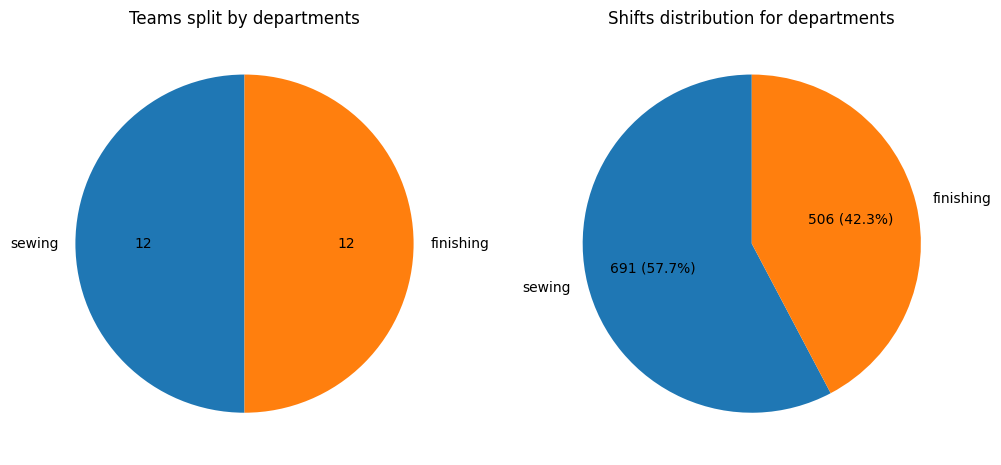

In [ ]:
shifts_dep_counts = df.department.value_counts()
labels_shifts = list(shifts_dep_counts.index)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[1].pie(shifts_dep_counts, labels=labels_shifts,
           autopct=pie_formatting, startangle=90)
axs[1].set_title('Shifts distribution for departments')


df_unique_teams = df[['department', 'team']].drop_duplicates()
team_dep_counts = df_unique_teams.department.value_counts()
labels_teams = list(shifts_dep_counts.index)

axs[0].pie(team_dep_counts, labels=labels_teams,
           autopct=lambda p: '{:.0f}'.format(p * sum(team_dep_counts) / 100), startangle=90)
axs[0].set_title('Teams split by departments')

plt.show()

What is timeline for shifts?

In [ ]:
print(f'The data is given for shifts from {df.date.min()} to {df.date.max()}')
print(f'On average, {round(df.date.value_counts().mean())} teams were working daily')
print(f'On average, teams were working {round(df[["department", "team"]].value_counts().mean())} shifts for the period')

The data is given for shifts from 2015-01-01 to 2015-03-11
On average, 20 teams were working daily
On average, teams were working 50 shifts for the period


In [ ]:
df.shape[0]

1197

How many teams met the target?

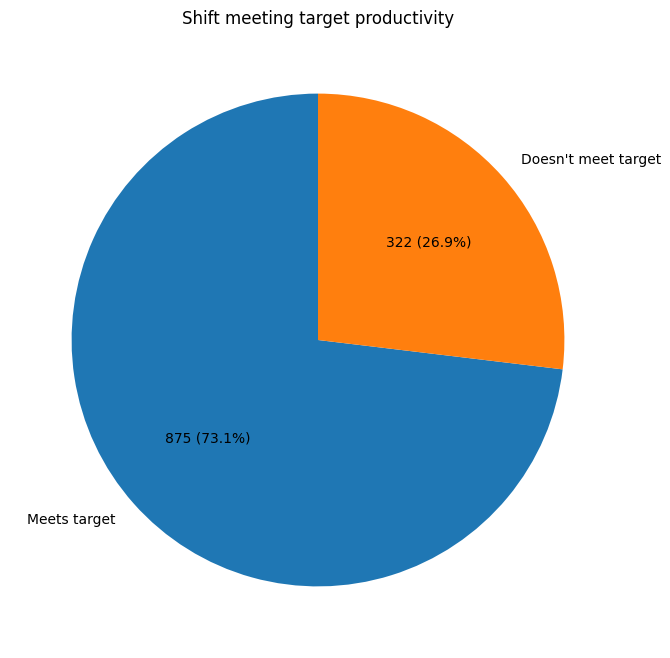

In [ ]:
filter = df.actual_productivity >= df.targeted_productivity
labels = ['Meets target', 'Doesn\'t meet target']

counts = filter.value_counts()
plt.figure(figsize=(8, 8))

plt.pie(counts, labels=labels, autopct=pie_formatting,  startangle=90)

plt.title('Shift meeting target productivity')
plt.show()

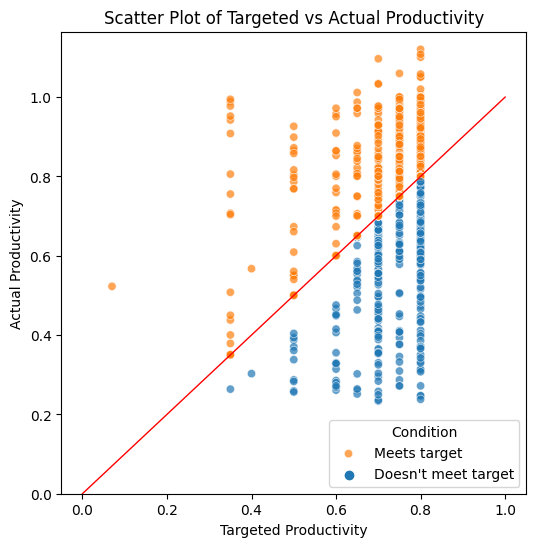

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='targeted_productivity', y='actual_productivity', hue=filter, data=df, alpha=0.7)
plt.ylim(bottom=0)

plt.plot([0, 1], [0, 1], color='red', linewidth=1)

plt.xlabel('Targeted Productivity')
plt.ylabel('Actual Productivity')
plt.title('Scatter Plot of Targeted vs Actual Productivity')
plt.legend(title='Condition', labels=labels)

plt.show()

In [ ]:
actual_max = df.actual_productivity.max()
actual_min = df.actual_productivity.min()
target_max = df.targeted_productivity.max()
target_min = df.targeted_productivity.min()
print(f'Target range {target_min}-{target_max}')
print(f'Actual range {actual_min}-{actual_max}')

Target range 0.07-0.8
Actual range 0.233705476-1.1204375


## Setting target
The goal is to classify teams productivity into categories low, medium_low, medium_higi, high. As we are given both targeted productivity and actual one, the classification will depend on how team did in regard to target productivity.

Thus, productivity delta is introduced. It is the difference between actual productivity and targeter productivity.

In [ ]:
df['productivity_delta'] = df.actual_productivity - df.targeted_productivity
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productivity_delta
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,0.140725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500,0.136500
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,0.000570
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,0.000570
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,0.000382


Let's look at the density

In [ ]:
green = '#2ca02c'

Histogram for distribution

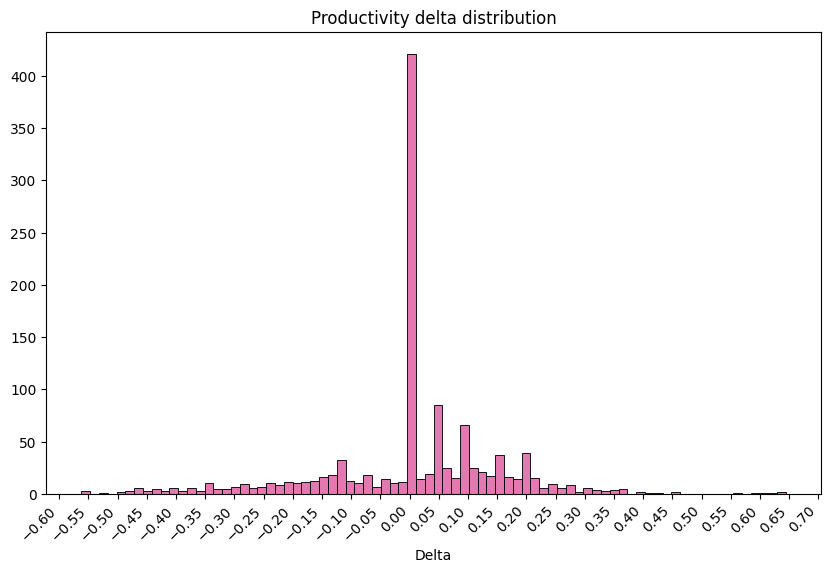

In [ ]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='productivity_delta', bins=80, color='#db4c99', edgecolor='black', label='Original Data')

plt.gca().xaxis.set_major_locator(MultipleLocator(0.05))
plt.xticks(rotation=45, ha="right")

plt.xlabel('Delta')
plt.ylabel(None)

plt.title('Productivity delta distribution')

plt.show()

In [ ]:
quartiles = df.productivity_delta.quantile([0.25, 0.5, 0.75])
print(quartiles)
quartiles = list(quartiles)

0.25   -0.009556
0.50    0.000505
0.75    0.099111
Name: productivity_delta, dtype: float64


<Axes: xlabel='productivity_delta'>

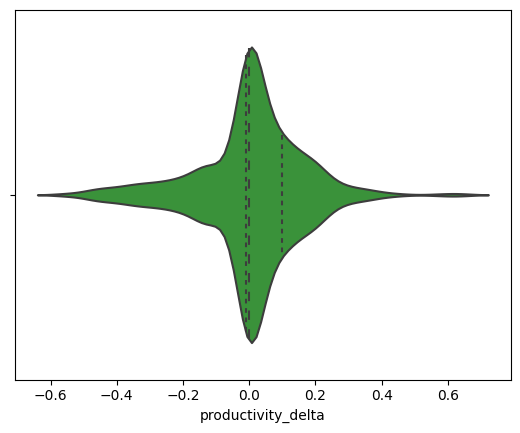

In [ ]:
sns.violinplot(x=df.productivity_delta, inner='quartile', color=green)

We are not given the specific productivity percentage borders for each class. The pattern will be drown out of data. The first idea is to use quartiles. Then the median is slightly above 0, which meansm that medium_high class starts not from zero, but from 0.0005. It seems not crucial, but in fact there are a lot of teams that performed with productivity delta between 0 and 0.0005. And they will fall to medium_low, which is not fair - they've reached the goal! Therefore, 0 will be dividing medium_low and medium_high, and the other borders are defined by quantiles.

In [ ]:
def assign_label1(num_value: float) -> str:
  if num_value < quartiles[0]:
    return 'low'
  elif num_value < 0:
    return 'medium_low'
  elif num_value <= quartiles[2]:
    return 'medium_high'
  else:
    return 'high'


df['actual_productivity_label'] = df.productivity_delta.apply(assign_label1)

Text(0, 0.5, '')

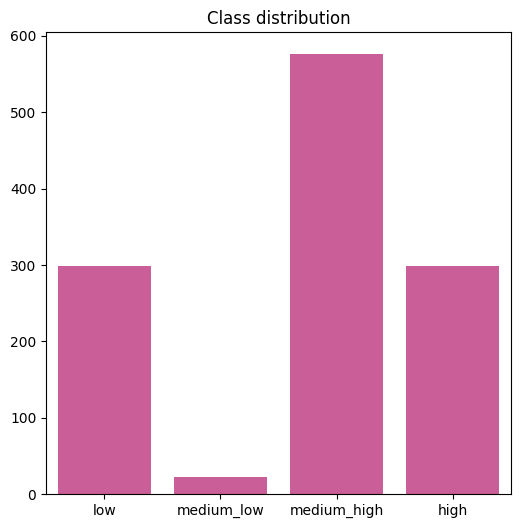

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='actual_productivity_label', color='#db4c99', order=['low', 'medium_low', 'medium_high', 'high'])
plt.title("Class distribution")
plt.xlabel(None)
plt.ylabel(None)

But then, there are quite a class imbalance, especially for medium_low, it is very misrepresented. We are then merge medium_low and low. Thus, we are working with 3 logical categories - low, medium, high.

In [ ]:
def assign_label2(num_value: float) -> str:
  if num_value < 0:
    return 'low'
  elif num_value <= quartiles[2]:
    return 'medium'
  else:
    return 'high'


df['actual_productivity_label'] = df.productivity_delta.apply(assign_label2)

In [ ]:
bar_order = ['low', 'medium', 'high']

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

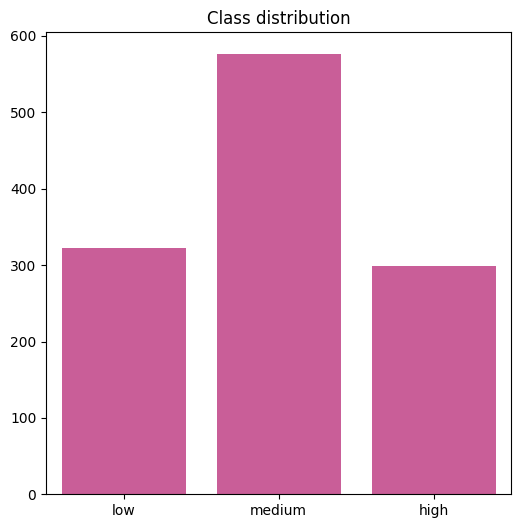

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='actual_productivity_label', color='#db4c99', order=bar_order)
plt.title("Class distribution")
plt.xlabel(None)
plt.ylabel(None)
plt

Now good class-related exploration


<ipython-input-23-2ae31853a401>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(correlated_df.corr(), dtype=np.bool)
<ipython-input-23-2ae31853a401>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlated_df.corr(), dtype=np.bool)
<ipython-input-23-2ae31853a401>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_on

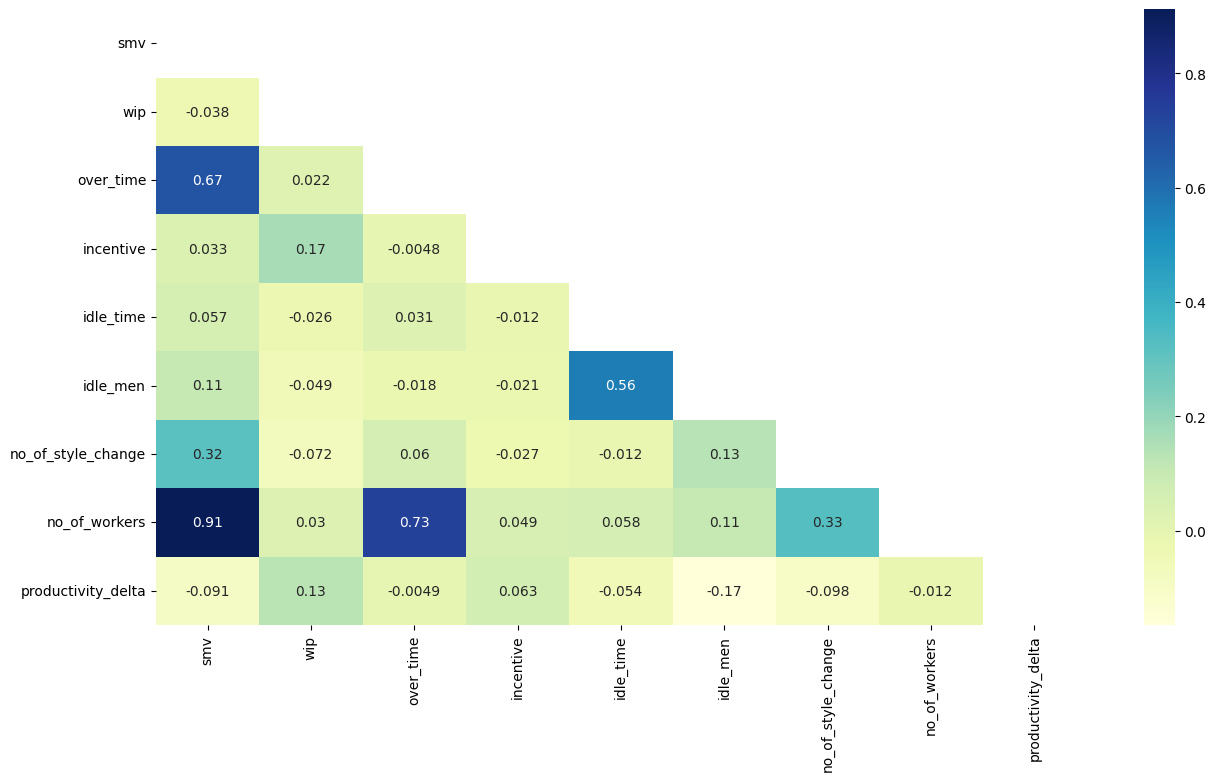

In [ ]:
correlated_df = df.drop(columns=['team', 'actual_productivity', 'targeted_productivity'])

fig, ax = plt.subplots(figsize=(15, 8))

mask = np.zeros_like(correlated_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(correlated_df.corr(), mask=mask, ax=ax, cmap='YlGnBu', annot=True)

Number of workers is highly correlated with SMV. SMV is being removed, as it is most likely derivative from number of workers.

## Exploration from target point of view

In [ ]:
class_order = ['low', 'medium', 'high']

In [ ]:
def plot_stacked_proportions(feature: str, df, title: str = None, legend_title: str = None) -> None:
  class_order = ['low', 'medium', 'high']
  distribution = pd.crosstab(df.actual_productivity_label, df[feature], normalize='index')
  ax = sns.barplot(data=distribution.iloc[:,::-1].cumsum(axis=1).stack().reset_index(name='distribution'),
            x='actual_productivity_label', y='distribution', hue=feature,
            hue_order=distribution.columns,
            dodge=False, order=class_order)
  plt.ylabel(None)
  plt.xlabel(None)
  plt.title(title)
  ax.legend(title=legend_title)

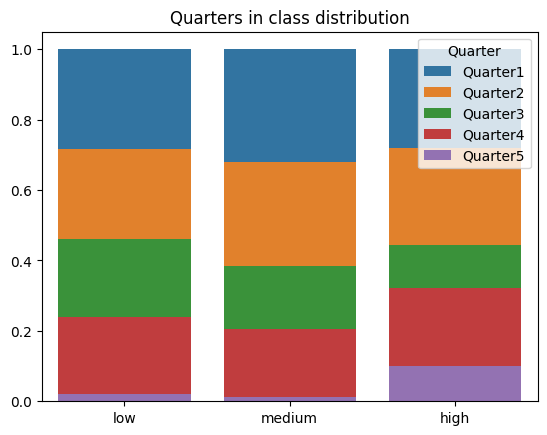

In [ ]:
plot_stacked_proportions('quarter', df, 'Quarters in class distribution', 'Quarter')

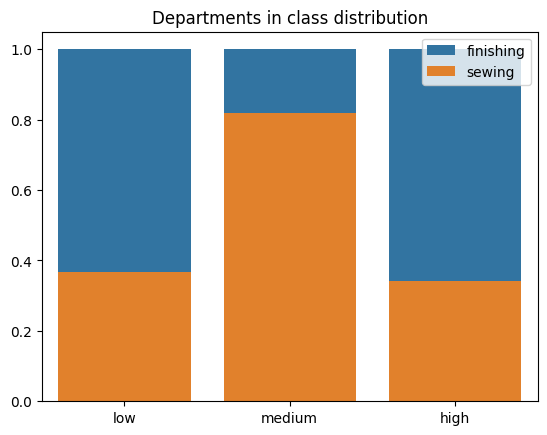

In [ ]:
plot_stacked_proportions('department', df, title='Departments in class distribution')

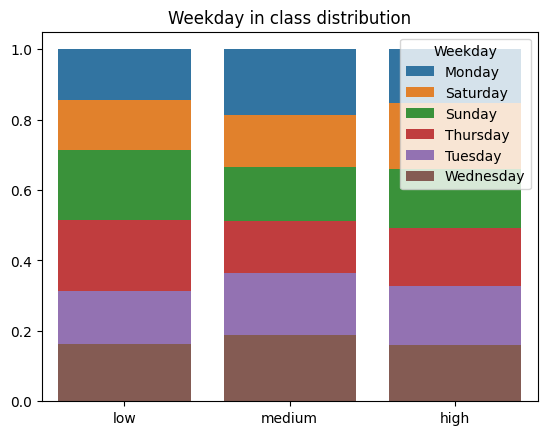

In [ ]:
plot_stacked_proportions('day', df, title='Weekday in class distribution', legend_title='Weekday')

In [ ]:
order = ['low', 'medium', 'high']

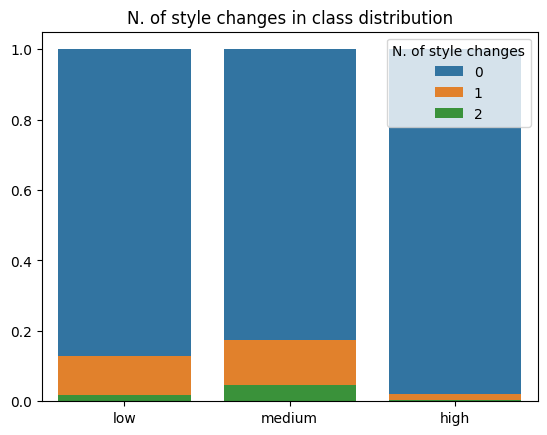

In [ ]:
plot_stacked_proportions('no_of_style_change', df, title='N. of style changes in class distribution', legend_title='N. of style changes')

In [ ]:
def class_has_feature_plot(feature: str, df, title: str):
  class_order = ['low', 'medium', 'high']

  df = df.copy()
  idicator_col_name = f'has_{feature}'
  df[idicator_col_name] = df[feature].apply(lambda x: f'Has {feature}' if bool(x) else f'No {feature}')

  distribution = pd.crosstab(df.actual_productivity_label, df[idicator_col_name], normalize='index')
  ax = sns.barplot(data=distribution.iloc[:,::-1].cumsum(axis=1).stack().reset_index(name='distribution'),
            x='actual_productivity_label', y='distribution', hue=idicator_col_name,
            hue_order=distribution.columns,
            dodge=False, order=class_order)

  plt.ylabel(None)
  plt.xlabel(None)
  plt.title(title)
  ax.legend(title=None)

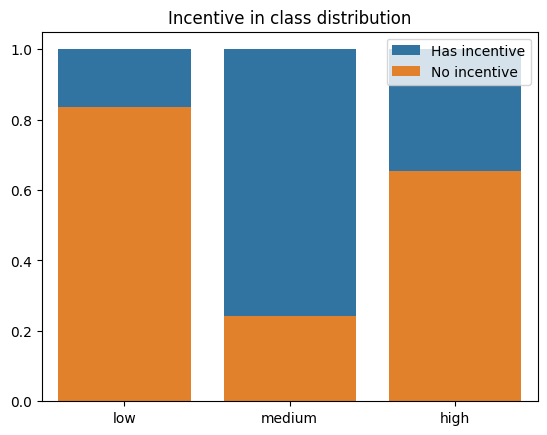

In [ ]:
class_has_feature_plot('incentive', df, 'Incentive in class distribution')

Idle men exploration

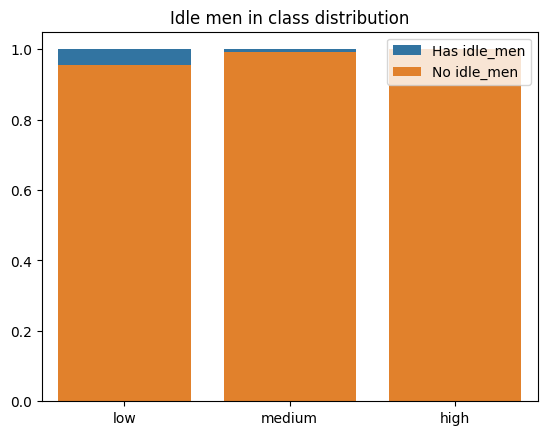

In [ ]:
class_has_feature_plot('idle_men', df, 'Idle men in class distribution')

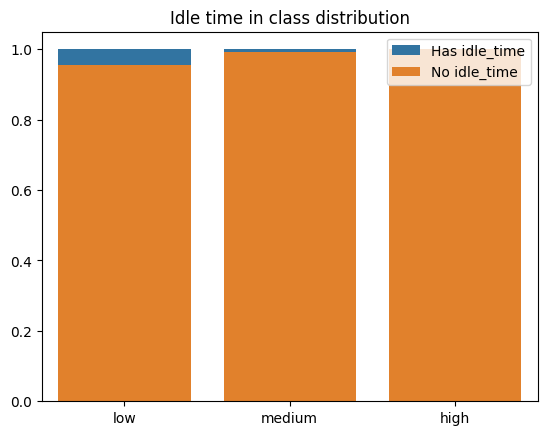

In [ ]:
class_has_feature_plot('idle_time', df, 'Idle time in class distribution')

In [ ]:
df.wip.fillna(0, inplace=True)

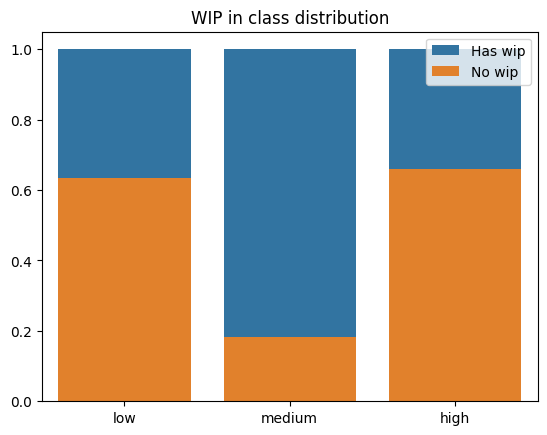

In [ ]:
class_has_feature_plot('wip', df, 'WIP in class distribution')

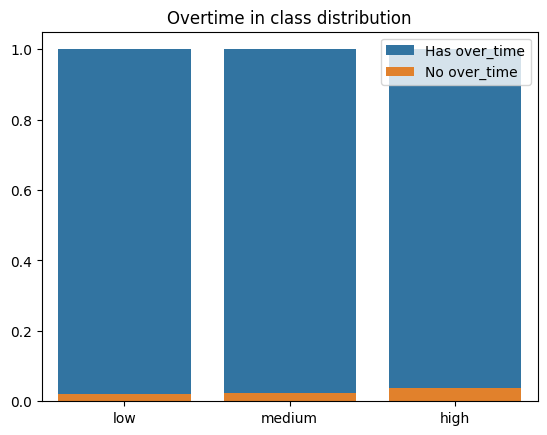

In [ ]:
class_has_feature_plot('over_time', df, 'Overtime in class distribution')

N. of workers short exploration

In [ ]:
low_df = df[df.actual_productivity_label == 'low']
medium_df = df[df.actual_productivity_label == 'medium']
high_df = df[df.actual_productivity_label == 'high']

print(f'Low productivity: average number of workers: {round(low_df.no_of_workers.mean())}, range: {low_df.no_of_workers.min()}-{low_df.no_of_workers.max()}')
print(f'Medium productivity: average number of workers: {round(medium_df.no_of_workers.mean())}, range: {medium_df.no_of_workers.min()}-{high_df.no_of_workers.max()}')
print(f'High productivity: average number of workers: {round(high_df.no_of_workers.mean())}, range: {high_df.no_of_workers.min()}-{high_df.no_of_workers.max()}')

Low productivity: average number of workers: 26, range: 2.0-60.0
Medium productivity: average number of workers: 44, range: 2.0-59.0
High productivity: average number of workers: 27, range: 2.0-59.0


Hyphotesis:
* Quarter, day of week have not a lot of effect on predictions, they are working by other schedule
* number of style changes and department does not really have big importance
* wip - cannot tell.
* over_time must help separate medium from other 2 classes
* Incentive must have influence for getting job done, but high productivity strives from different aspects
*  idle time and idle man must be bringing negative influence on result
*  department will have huge influence

## Clean data

In [ ]:
df.isna().sum()

date                         0
quarter                      0
department                   0
day                          0
team                         0
targeted_productivity        0
smv                          0
wip                          0
over_time                    0
incentive                    0
idle_time                    0
idle_men                     0
no_of_style_change           0
no_of_workers                0
actual_productivity          0
productivity_delta           0
actual_productivity_label    0
dtype: int64

### Encoding time

In [ ]:
df.actual_productivity_label.replace({'low': 0, 'medium': 1, 'high': 2}, inplace=True)
target_labels = ['low', 'medium', 'high']

In [ ]:
df = pd.get_dummies(df, columns=['quarter', 'day', 'department'])

date, team, targeted and actual productivity are to be removed. smv as well, as it is very correlated with number of workers and derivative in its nature

In [ ]:
df.columns

Index(['date', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time',
       'incentive', 'idle_time', 'idle_men', 'no_of_style_change',
       'no_of_workers', 'actual_productivity', 'productivity_delta',
       'actual_productivity_label', 'quarter_Quarter1', 'quarter_Quarter2',
       'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'department_finishing',
       'department_sewing'],
      dtype='object')

In [ ]:
features = ['wip', 'over_time', 'incentive', 'idle_time',
            'idle_men', 'no_of_style_change', 'no_of_workers',
            'department_finishing', 'department_sewing']
target = 'actual_productivity_label'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

<Axes: xlabel='incentive'>

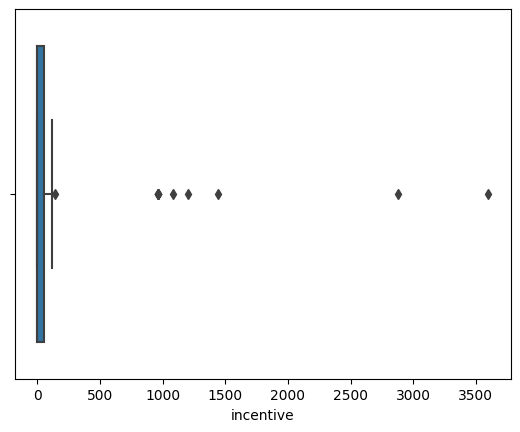

In [ ]:
sns.boxplot(x='incentive', data=df)

<Axes: xlabel='idle_men'>

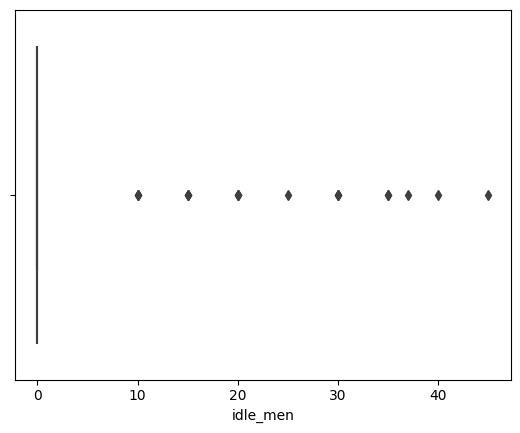

In [ ]:
sns.boxplot(x='idle_men', data=df)

There are a lot of columns with outliers. We will use Standard scaler

In [ ]:
features_to_scale = ['wip', 'over_time', 'incentive', 'idle_time',
                     'idle_men', 'no_of_style_change', 'no_of_workers']

scaler = StandardScaler()
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

## Models

### Evaluation toolbox

In [ ]:
def print_classification_report(y_test, y_pred, names):
  print(classification_report(y_test, y_pred, target_names=names))

In [ ]:
def display_confusion_matrix(y_test, y_pred, names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion Matrix (Absolute Values)
    cm_absolute = confusion_matrix(y_test, y_pred)
    disp_absolute = ConfusionMatrixDisplay(confusion_matrix=cm_absolute, display_labels=names)
    disp_absolute.plot(values_format='d', ax=axes[0], colorbar=False, cmap='PuRd')
    axes[0].set_title('Confusion Matrix (Absolute Values)')

    # Confusion Matrix (Proportions)
    cm_proportions = confusion_matrix(y_test, y_pred).astype('float') / confusion_matrix(y_test, y_pred).sum(axis=1)[:, np.newaxis]
    disp_proportions = ConfusionMatrixDisplay(confusion_matrix=cm_proportions, display_labels=names)
    disp_proportions.plot(values_format='.2f', ax=axes[1], colorbar=False, cmap='PuRd')
    axes[1].set_title('Confusion Matrix (Proportions)')

    plt.subplots_adjust(wspace=0.5)

    plt.show()

In [ ]:
def get_aucs(y_test, y_test_predict_proba):
  y_test = np.ravel(y_test)
  y_test_predict_proba = y_test_predict_proba.reshape(-1, y_test_predict_proba.shape[-1])

  auc_micro = roc_auc_score(y_test, y_test_predict_proba, multi_class='ovr', average='micro')
  print(f'Micro-Averaged AUC: {auc_micro}')

  auc_macro = roc_auc_score(y_test, y_test_predict_proba, multi_class='ovr', average='macro')
  print(f'Macro-Averaged AUC: {auc_macro}')

  return auc_micro, auc_macro

In [ ]:
def plot_aucs(y_test, y_test_pred_proba):
  fig, ax = plt.subplots(figsize=(8, 8))

  y_test = pd.get_dummies(y_test).values
  for i in range(y_test.shape[1]):
      fpr, tpr, _ = roc_curve(y_test[:, i], y_test_pred_proba[:, i])
      roc_auc = auc(fpr, tpr)

      sns.lineplot(x=fpr, y=tpr, label=f'Class {i} (AUC = {roc_auc:.2f})', ax=ax)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves - One-vs-Rest (ovr)')
  plt.legend()

  plt.show()

In [ ]:
def get_best_params(model, param_grid: dict, X, y, cv: int = 5) -> dict:
  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=2,
  )
  grid_search.fit(X, y)
  return grid_search.best_params_

In [ ]:
def visualize_feature_importances(model, names):
  feat_importances = pd.Series(model.feature_importances_, index=names).sort_values(ascending=False)
  feat_importances.plot(kind='barh', color='#db4c99')

### Logistic regression

In [ ]:
param_grid = {
  'penalty': ['l1', 'l2', 'elasticnet', 'none'],
  'C': [0.001, 0.01, 0.1, 1, 10, 100],
  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
  'multi_class': ['auto', 'ovr', 'multinomial'],
  'class_weight': [None, 'balanced'],
  'max_iter': [1500, 2500]
}

# lr_best_params = get_best_params(LogisticRegression(), param_grid, X_train, y_train)

In [ ]:
# lr_best_params
lr_best_params = {'C': 10,
 'class_weight': 'balanced',
 'max_iter': 1500,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'liblinear'}

In [ ]:
best_lr = LogisticRegression(**lr_best_params)
best_lr.fit(X_train, y_train)

y_test_pred_lr = best_lr.predict(X_test)
y_train_pred_lr = best_lr.predict(X_train)
y_test_pred_proba_lr = best_lr.predict_proba(X_test)
y_train_pred_proba_lr = best_lr.predict_proba(X_train)

ac_test_lr = accuracy_score(y_test_pred_lr, y_test)
ac_test_lr

0.6233333333333333

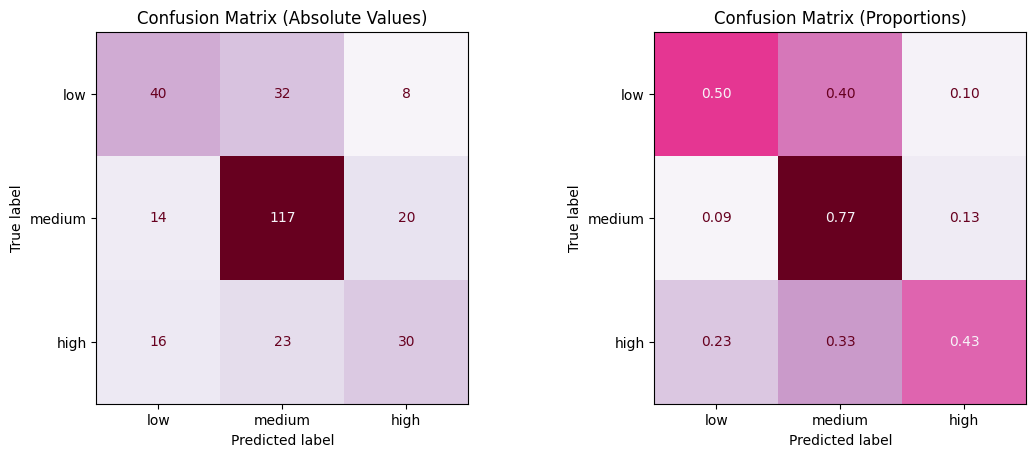

In [ ]:
display_confusion_matrix(y_test, y_test_pred_lr, target_labels)

In [ ]:
print_classification_report(y_test, y_test_pred_lr, target_labels)

              precision    recall  f1-score   support

         low       0.57      0.50      0.53        80
      medium       0.68      0.77      0.72       151
        high       0.52      0.43      0.47        69

    accuracy                           0.62       300
   macro avg       0.59      0.57      0.58       300
weighted avg       0.61      0.62      0.62       300



In [ ]:
micro_auc_test_lr, macro_auc_test_lr = get_aucs(y_test, y_test_pred_proba_lr)

Micro-Averaged AUC: 0.7597722222222222
Macro-Averaged AUC: 0.733327984201198


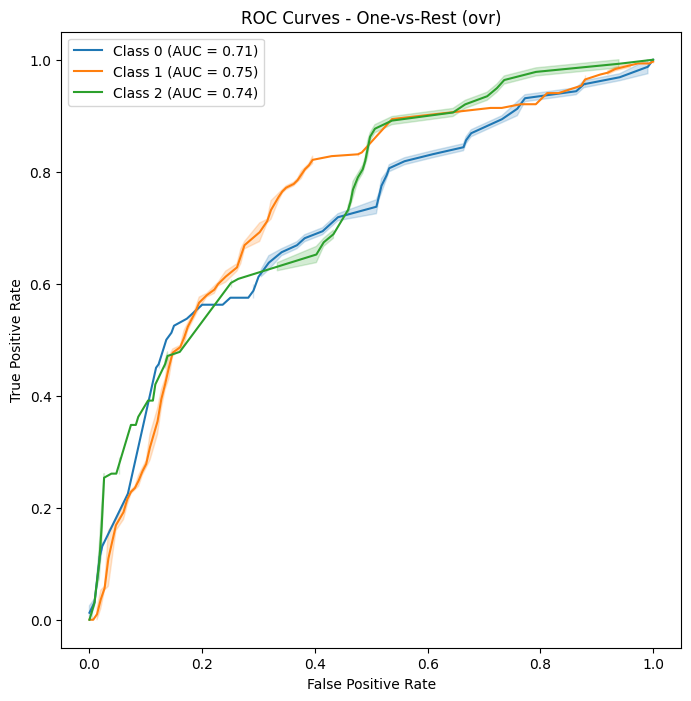

In [ ]:
plot_aucs(y_test, y_test_pred_proba_lr)

In [ ]:
coefs = best_lr.coef_
coef_df = pd.DataFrame({
    'Feature': features,
    'High class coefs': coefs[2],
    'Medium class coefs': coefs[1],
    'Low class coefs': coefs[0],
    'high_sort': np.abs(coefs[2]),
    'medium_sort': np.abs(coefs[1]),
    'low_sort': np.abs(coefs[0]),
})

sort_cols = ['high_sort', 'medium_sort', 'low_sort']
coef_df = coef_df.sort_values(by=sort_cols, ascending=False).reset_index(drop=True)
coef_df.drop(columns=sort_cols, inplace=True)
coef_df

,Feature,High class coefs,Medium class coefs,Low class coefs
0,department_sewing,-4.709352,2.416765,-0.398288
1,no_of_workers,4.204459,-1.806365,-0.262773
2,department_finishing,4.062815,-2.947526,-0.300087
3,no_of_style_change,-1.172230,0.238575,0.178798
4,idle_men,-0.856646,-0.365261,0.419210
5,over_time,-0.606991,0.224108,0.165611
6,wip,0.239847,-0.110635,-1.790798
7,idle_time,-0.121700,0.209941,-0.193815
8,incentive,-0.030310,0.090761,-0.083745


### Random Forest

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 30, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt']
}

# forest_best_params = get_best_params(RandomForestClassifier(), param_grid, X_train, y_train)

In [ ]:
# forest_best_params
forest_best_params = {'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
best_forest = RandomForestClassifier(**forest_best_params)
best_forest.fit(X_train, y_train)

y_test_pred_forest = best_forest.predict(X_test)
y_test_train_forest = best_forest.predict(X_train)
y_test_pred_proba_forest = best_forest.predict_proba(X_test)

ac_test_forest = accuracy_score(y_test, y_test_pred_forest)
ac_test_forest

0.7066666666666667

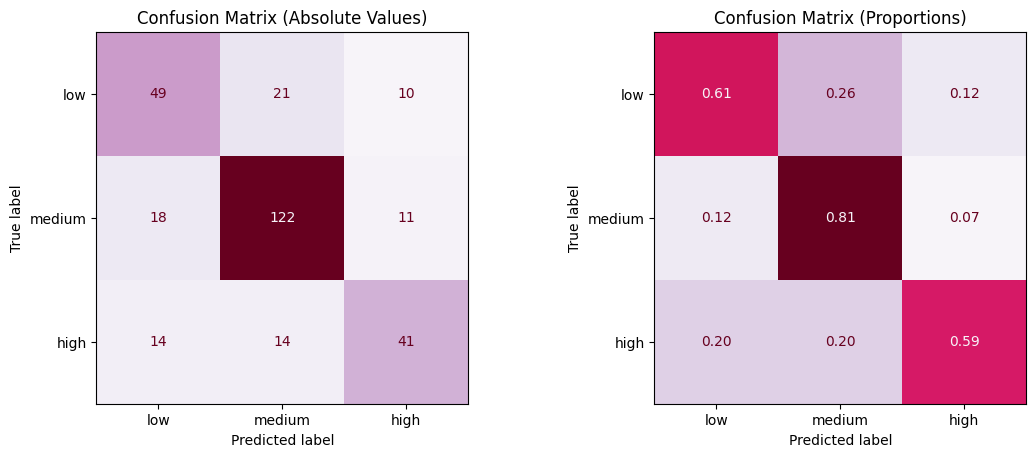

In [ ]:
display_confusion_matrix(y_test, y_test_pred_forest, target_labels)

In [ ]:
print_classification_report(y_test, y_test_pred_forest, target_labels)

              precision    recall  f1-score   support

         low       0.60      0.61      0.61        80
      medium       0.78      0.81      0.79       151
        high       0.66      0.59      0.63        69

    accuracy                           0.71       300
   macro avg       0.68      0.67      0.68       300
weighted avg       0.70      0.71      0.71       300



In [ ]:
micro_auc_test_forest, macro_auc_test_forest = get_aucs(y_test, y_test_pred_proba_forest)

Micro-Averaged AUC: 0.8519277777777778
Macro-Averaged AUC: 0.8323993347515782


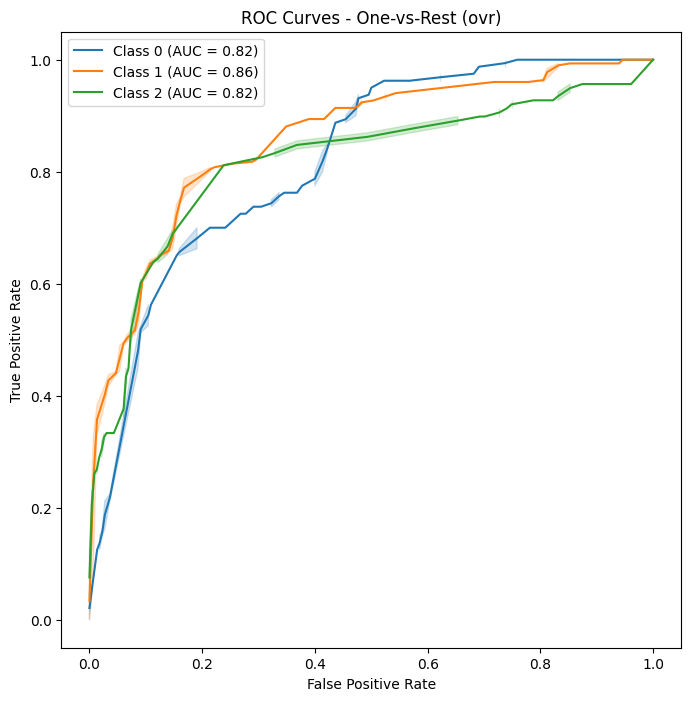

In [ ]:
plot_aucs(y_test, y_test_pred_proba_forest)

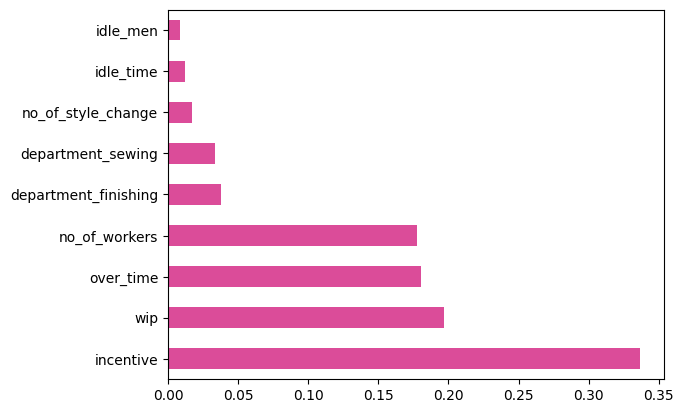

In [ ]:
visualize_feature_importances(best_forest, features)

### SVC

In [ ]:
param_grid = {
  'C': [0.1, 1, 10, 100],
  'kernel': ['linear', 'rbf', 'poly'],
  'gamma': ['scale', 'auto', 0.1, 1],
  'degree': [2, 3, 4, 5],
  'coef0': [0.0, 0.1, 0.5],
  'shrinking': [True, False],
  'class_weight': [None, 'balanced'],
  'decision_function_shape': ['ovr', 'ovo'],
}

# # svc_best_params = get_best_params(SVC(probability=True), param_grid, X_train, y_train)

In [ ]:
# svc_best_params
svc_best_params = {'C': 10,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 1,
 'kernel': 'rbf',
 'shrinking': True}

In [ ]:
best_svc = SVC(**svc_best_params, probability=True)
best_svc.fit(X_train, y_train)

y_test_pred_svc = best_svc.predict(X_test)
y_test_train_svc = best_svc.predict(X_train)
y_test_pred_proba_svc = best_svc.predict_proba(X_test)

ac_test_svc = accuracy_score(y_test, y_test_pred_svc)
ac_test_svc

0.69

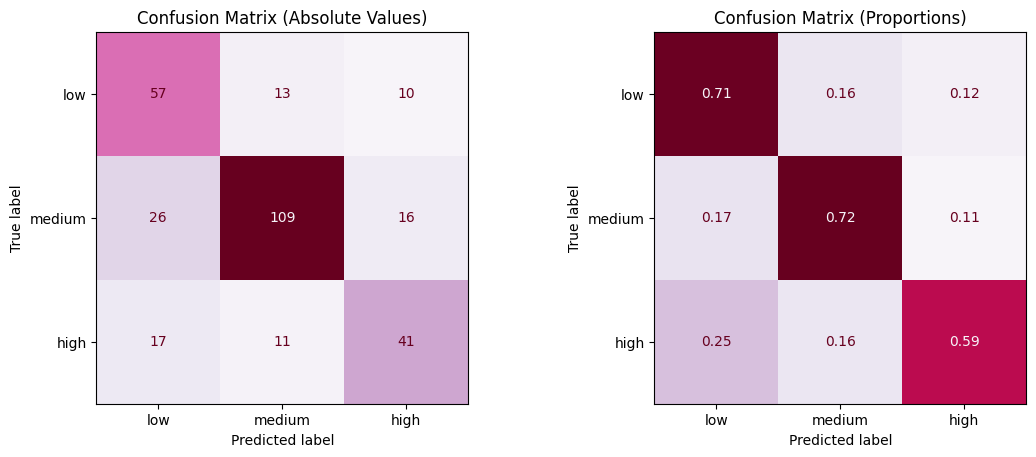

In [ ]:
display_confusion_matrix(y_test, y_test_pred_svc, target_labels)

In [ ]:
print_classification_report(y_test, y_test_pred_svc, target_labels)

              precision    recall  f1-score   support

         low       0.57      0.71      0.63        80
      medium       0.82      0.72      0.77       151
        high       0.61      0.59      0.60        69

    accuracy                           0.69       300
   macro avg       0.67      0.68      0.67       300
weighted avg       0.71      0.69      0.69       300



In [ ]:
micro_auc_test_svc, macro_auc_test_svc = get_aucs(y_test, y_test_pred_proba_svc)

Micro-Averaged AUC: 0.8490000000000002
Macro-Averaged AUC: 0.8281549742985698


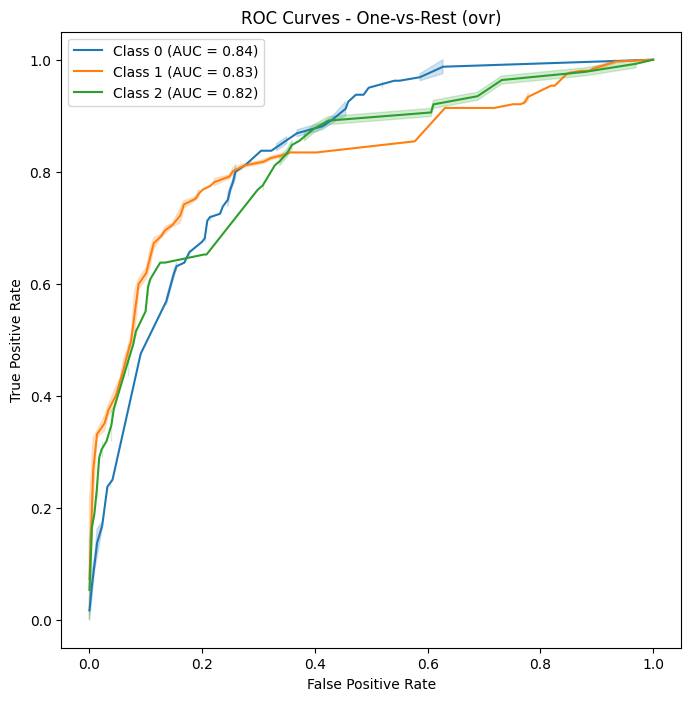

In [ ]:
plot_aucs(y_test, y_test_pred_proba_svc)

## Neural network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D


def build_nn_model(input_dim, hidden_dims: set[int], regularizer=None,
                   activation: str = 'relu', output_activation: str = 'sigmoid',
                   outputs: int = 1):
  model = Sequential()

  model.add(Dense(units=hidden_dims[0],
                  input_dim=input_dim,
                  kernel_initializer='normal',
                  kernel_regularizer=regularizer, activation=activation))

  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  for i in range(1, len(hidden_dims)):
    model.add(Dense(units=hidden_dims[i],
                    kernel_initializer='normal',
                    kernel_regularizer=regularizer, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

  model.add(Dense(units=outputs,
                  kernel_initializer='normal',
                  kernel_regularizer=regularizer,  activation=output_activation))

  return model

In [ ]:
def plot_history(story):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  ax1 = axes[0]

  loss_over_epoch_train = story.history['loss']
  sns.lineplot(loss_over_epoch_train, label='Loss on train data', ax=ax1)

  loss_over_epoch_test = story.history['val_loss']
  sns.lineplot(loss_over_epoch_test, label='Loss on validation data', ax=ax1)

  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  ax2 = axes[1]

  sns.lineplot(story.history['accuracy'], label='Accuracy on train data', ax=ax2)
  sns.lineplot(story.history['val_accuracy'], label='Accuracy on validation data', ax=ax2)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

In [ ]:
hidden_dims = (32, 32)
num_outputs = len(target_labels)
input_dim = X_train.shape[1]

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = build_nn_model(input_dim, hidden_dims, outputs=num_outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320       
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)               

Test binary crossentropy 0.9070446491241455, test accuracy 0.6133333444595337


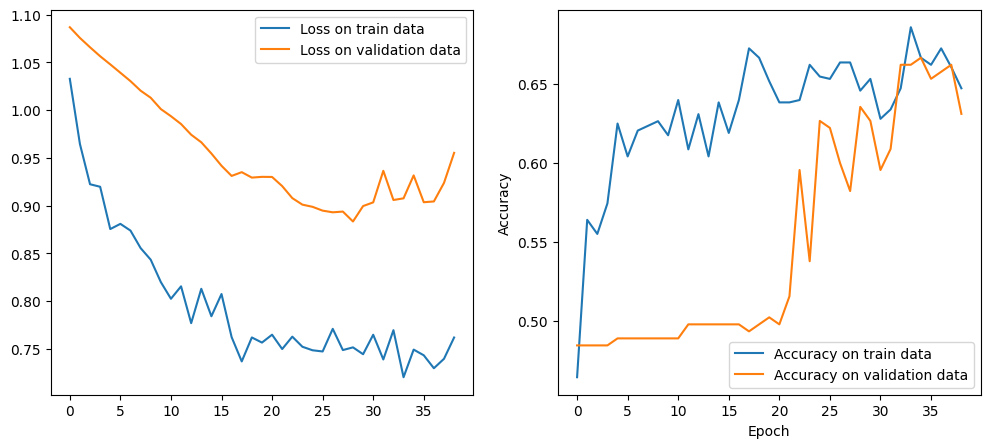

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(monitor='val_loss', min_delta=0.01, verbose=0, patience=10, restore_best_weights=True)

story = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.25
                   , callbacks=[early_stopping_cb]
                   )

test_metrics = model.evaluate(X_test, y_test, verbose=0)
print(f'Test binary crossentropy {test_metrics[0]}, test accuracy {test_metrics[1]}')
ac_test_nn = test_metrics[1]

plot_history(story)

In [ ]:
y_test_pred_nn_proba = model.predict(X_test, verbose=0)
y_test_pred_nn = np.argmax(y_test_pred_nn_proba, axis=1)

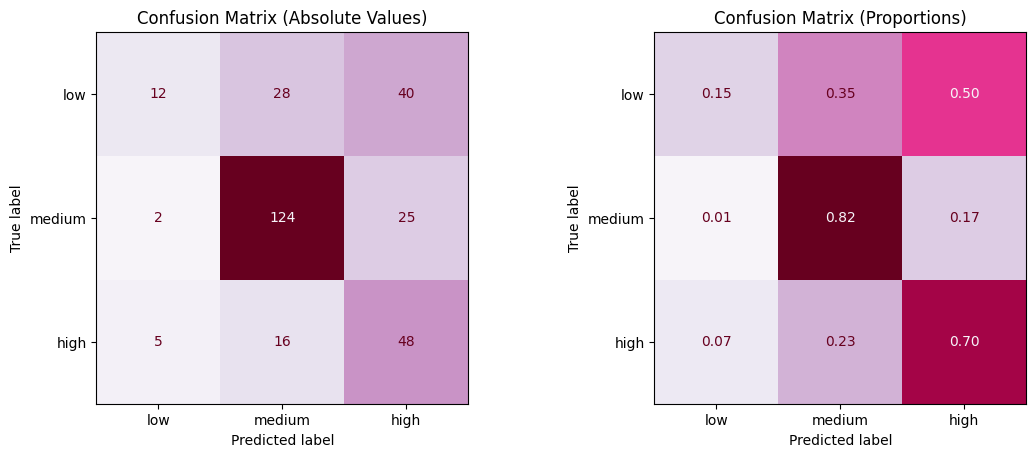

In [ ]:
display_confusion_matrix(y_test, y_test_pred_nn, target_labels)

In [ ]:
 print_classification_report(y_test, y_test_pred_nn, target_labels)

              precision    recall  f1-score   support

         low       0.63      0.15      0.24        80
      medium       0.74      0.82      0.78       151
        high       0.42      0.70      0.53        69

    accuracy                           0.61       300
   macro avg       0.60      0.56      0.52       300
weighted avg       0.64      0.61      0.58       300



In [ ]:
from sklearn.preprocessing import label_binarize

def get_aucs_keras(y_test, y_test_predict_proba):
  y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

  auc_micro = roc_auc_score(y_test_bin, y_test_predict_proba, multi_class='ovr', average='micro')
  print(f'Micro-Averaged AUC: {auc_micro}')

  auc_macro = roc_auc_score(y_test_bin, y_test_predict_proba, multi_class='ovr', average='macro')
  print(f'Macro-Averaged AUC: {auc_macro}')

  return auc_micro, auc_macro

In [ ]:
micro_auc_test_nn, macro_auc_test_nn = get_aucs_keras(y_test, y_test_pred_nn_proba)

Micro-Averaged AUC: 0.8221611111111111
Macro-Averaged AUC: 0.8178980814808421


### Comparison

In [ ]:
display_df = pd.DataFrame(columns=['Model', 'Macro AUC', 'Micro AUC', 'Accuracy'])
models = ['Logistic regression', 'Random Forest',
          'Support Vector Machine (rbf)',
          'Neural network 32x23']
macro_aucs = [macro_auc_test_lr, macro_auc_test_forest,
              macro_auc_test_svc,
              macro_auc_test_nn]
micro_aucs = [micro_auc_test_lr, micro_auc_test_forest,
              micro_auc_test_svc,
              micro_auc_test_nn]
acs = [ac_test_lr, ac_test_forest,
       ac_test_svc,
       ac_test_nn]

display_df = pd.DataFrame({
    'Model': models,
    'Macro AUC': macro_aucs,
    'Micro AUC': micro_aucs,
    'Accuracy': acs
})
display_df = display_df.round({'Macro AUC': 3, 'Micro AUC': 3, 'Accuracy': 3})

display_df

,Model,Macro AUC,Micro AUC,Accuracy
0,Logistic regression,0.733,0.760,0.623
1,Random Forest,0.832,0.852,0.707
2,Support Vector Machine (rbf),0.828,0.849,0.690
3,Neural network 32x23,0.818,0.822,0.613


## Interpretation

In [ ]:
# results_df = pd.concat([X_test_unscaled.reset_index(drop=True),
#                         pd.DataFrame({
#                           'actual_productivity_label': y_test,
#                           'predicted_class': y_test_pred_lr
#                         }).reset_index(drop=True),
#                         pd.DataFrame(y_test_pred_proba_lr,
#                                      columns=['prob_low', 'prob_medium', 'prob_high']).reset_index(drop=True)
#                         ],
#                        axis=1)
# results_df.department = results_df.department.apply(lambda x: department_encoder.classes_[x])
# results_df.predicted_class = results_df.predicted_class.apply(lambda x: target_labels[x])
# results_df.actual_productivity_label = results_df.actual_productivity_label.apply(lambda x: target_labels[x])

# results_df.shape

AttributeError: ignored

In [ ]:
results_df.loc[:, ['predicted_class', 'prob_low', 'prob_medium', 'prob_high']]

In [ ]:
correct_results_df = results_df[results_df.predicted_class == results_df.actual_productivity_label]
correct_results_df.shape

### Department

In [ ]:
sns.countplot(data=results_df, x='predicted_class', hue='department', order=order)

In [ ]:
def plot_histogram(df, x: str = None, title: str = None, x_title: str = None, ticks: int = 5):
  plt.figure(figsize=(10, 6))

  sns.histplot(data=df, x=x, bins=80, color=green, edgecolor='black')

  plt.gca().xaxis.set_major_locator(MultipleLocator(ticks))

  plt.xlabel(x_title)
  plt.ylabel(None)
  plt.title(title)

  plt.show()

In [ ]:
low_df = results_df[results_df.predicted_class == 'low']
medium_df = results_df[results_df.predicted_class == 'medium']
high_df = results_df[results_df.predicted_class == 'high']

### Incentive

In [ ]:
print(low_df.incentive.mean(), low_df.incentive.std())
print(medium_df.incentive.mean(), medium_df.incentive.std())
print(high_df.incentive.mean(), high_df.incentive.std())

In [ ]:
plot_histogram(low_df, 'incentive',  'Incentive distribution for low productivity shifts', 'Incentive')

In [ ]:
plot_histogram(medium_df, 'incentive', 'Incentive distribution for medium productivity shifts', 'Incentive', 50)

In [ ]:
plot_histogram(high_df, 'incentive', 'Incentive distribution for high productivity shifts', 'Incentive', 50)

### Overtime

In [ ]:
print(low_df.over_time.mean(), low_df.over_time.std())
print(medium_df.over_time.mean(), medium_df.over_time.std())
print(high_df.over_time.mean(), high_df.over_time.std())

In [ ]:
X_train_unscaled.over_time.max()

In [ ]:
plot_histogram(low_df, 'over_time', 'Overtime distribution for low productivity shifts', 'Overtime', 1000)

In [ ]:
plot_histogram(medium_df, 'over_time', 'Overtime distribution for medium productivity shifts', 'Overtime', 1000)

In [ ]:
plot_histogram(high_df, 'over_time', 'Overtime distribution for high productivity shifts', 'Overtime', 1000)

In [ ]:
print(low_df.wip.mean(), low_df.wip.std())
print(medium_df.wip.mean(), medium_df.wip.std())
print(high_df.wip.mean(), high_df.wip.std())

### Number of workers

In [ ]:
print(low_df.no_of_workers.mean(), low_df.no_of_workers.std())
print(medium_df.no_of_workers.mean(), medium_df.no_of_workers.std())
print(high_df.no_of_workers.mean(), high_df.no_of_workers.std())

In [ ]:
plot_histogram(low_df, 'no_of_workers', 'N. of workers', 'N. of workers distribution for low productivity shifts')

In [ ]:
plot_histogram(medium_df, 'no_of_workers', 'N. of workers', 'N. of workers distribution for medium productivity shifts')

In [ ]:
plot_histogram(high_df, 'no_of_workers', 'N. of workers', 'N. of workers distribution for high productivity shifts')